In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import sacc
import camb
import ast
import time
from camb.correlations import lensed_cl_derivatives

In [2]:
# Read lensing binning matrix

lensing_binning_matrix = np.loadtxt("data/lensing_binning_matrix.txt")
lmax_kk = len(lensing_binning_matrix[0])
nb_bins_kk = len(lensing_binning_matrix)
ell_kk = np.arange(lmax_kk)
ell_kk_center=lensing_binning_matrix.dot(np.arange(lmax_kk))

In [3]:
# Load CMB temperature/polarization data, covariance and bandpowers

s = sacc.Sacc.load_fits("data/data_sacc_w_covar_and_Bbl.fits")

In [4]:
# Extract cosmological parameters, fsky, lmax

fsky = float(s.metadata['f_sky_LAT'])
cosmo = ast.literal_eval(s.metadata['cosmo_params'])
cosmomc_theta = cosmo['cosmomc_theta']
As = 1e-10*np.exp(cosmo['logA'])
ombh2 = cosmo['ombh2']
omch2 = cosmo['omch2']
ns = cosmo['ns']
Alens = cosmo['Alens']
tau = cosmo['tau']

lmax_CMB = int(s.metadata['lmax'])+1

In [5]:
# Compute power spectra with CAMB, required to then compute derivatives

pars = camb.set_params(ombh2=ombh2, omch2=omch2, cosmomc_theta=cosmomc_theta, tau=tau, \
                       As=As, ns=ns, Alens=Alens)


pars.set_for_lmax(lmax_CMB)
results = camb.get_results(pars)
cls = results.get_unlensed_total_cls(CMB_unit='muK')[0:lmax_CMB+1,:]
clp = results.get_lens_potential_cls(CMB_unit='muK')[0:lmax_CMB+1,0]
cl_kk = np.pi/2*clp[0:lmax_kk]

In [6]:
# Compute derivatives, takes about 20mn to run

t1 = time.time()
dCllens = lensed_cl_derivatives(cls, clp)
t2 = time.time()
print(t2-t1)

1056.3923768997192


In [7]:
# Compute cross-covariance matrix between l(l+1)/(2*pi)C_l^{TT,EE,TE} and C_l^{kk} 
# (no prefactor before C_l^{kk})
# Using the center of CMB lensing bins


XCov_center = np.zeros((s.mean.size,nb_bins_kk))
index_cmb = 0
for comb in s.get_tracer_combinations():
    (t1, t2) = comb
    if t1[-1] == '0' and t2[-1] == '0':
        # TT case
        ind = s.indices('cl_00', comb)
        ind_CAMB = 0
    elif t1[-1] == '2' and t2[-1] == '2':
        # EE case
        ind = s.indices('cl_ee', comb)
        ind_CAMB = 1
    else:
        # TE case
        ind = s.indices('cl_0e', comb)
        ind_CAMB = 3
    bpw = s.get_bandpower_windows(ind)
    w = bpw.weight.T
    for k in range(len(w)):
        for j in range(nb_bins_kk):
            ell1 = int(ell_kk_center[j])
            XCov_center[index_cmb,j] = np.sum(w[k]*dCllens[ind_CAMB,bpw.values,ell1]*2*cl_kk[ell1] \
                               / (2*ell1+1))/fsky
        index_cmb += 1

In [9]:
import copy

Cov_kk = np.loadtxt("data/lensingbinnedcov.txt")

XCorr = copy.deepcopy(XCov_center)
for k in range(len(XCorr)):
    for j in range(len(XCorr[0])):
        XCorr[k,j] = XCov_center[k,j]/np.sqrt(Cov_kk[j,j]*s.covariance.covmat[k,k])

<IPython.core.display.Javascript object>


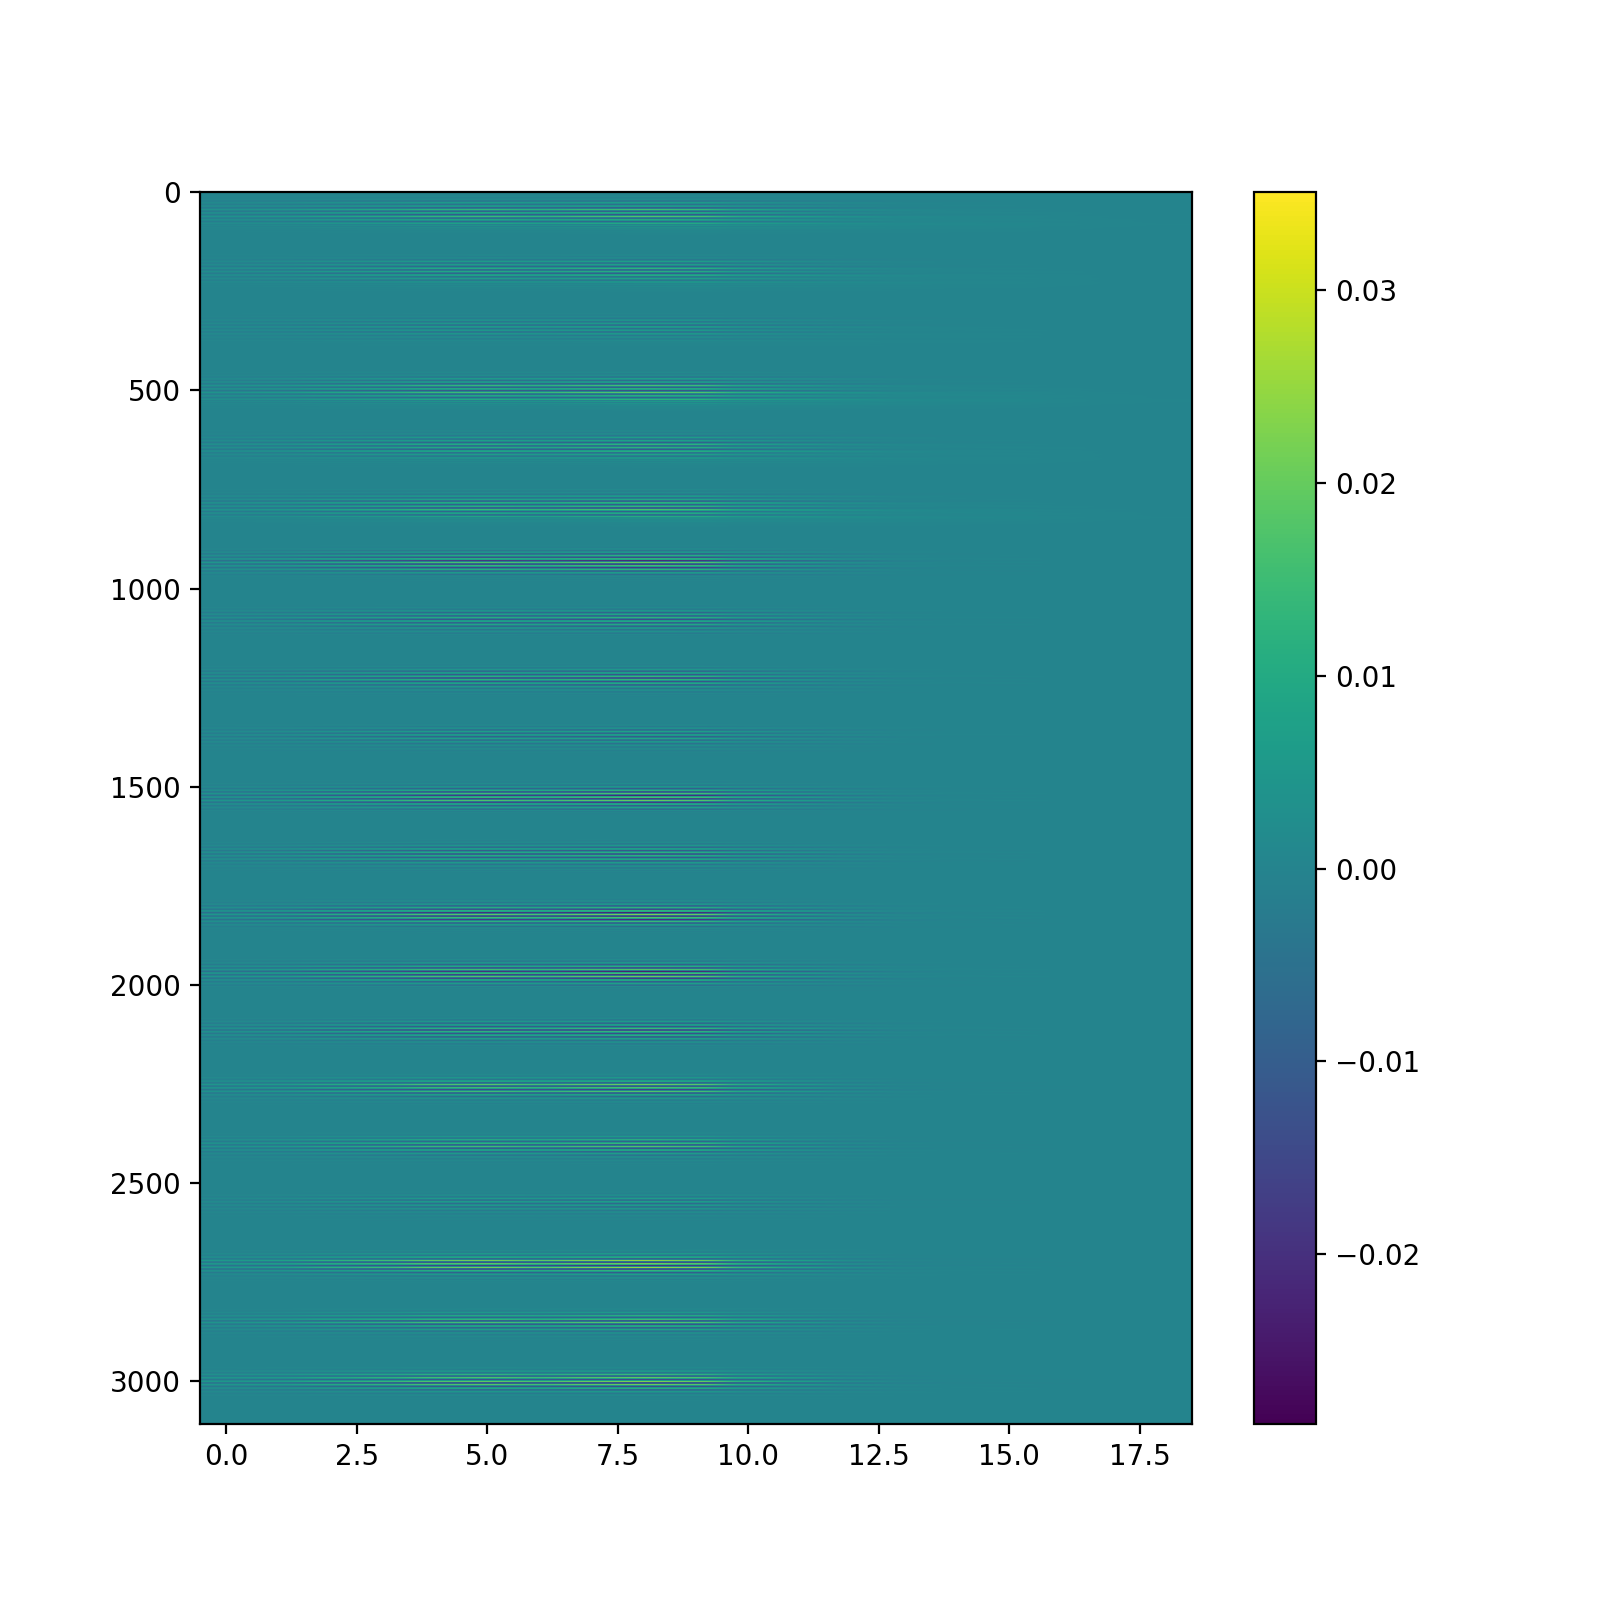

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(XCorr, aspect='auto')
plt.colorbar()

In [11]:
# Save cross-covariance
hdu = fits.PrimaryHDU(data=XCov_center)
hdu.writeto('products/XCov.fits')

# Averaging over CMB lensing multipoles rather than using center of bin
## (not required)

In [12]:
# Compute cross-covariance matrix between l(l+1)/(2*pi)C_l^{TT,EE,TE} and C_l^{kk} 
# (no prefactor before C_l^{kk})
# Difference with above: Average over CMB lensing multipoles rather than using the center of the bin
# However, runs in about 2 hours instead of few seconds

XCov_binned = np.zeros((s.mean.size,nb_bins_kk))

index_cmb = 0
for comb in s.get_tracer_combinations():
    (t1, t2) = comb
    if t1[-1] == '0' and t2[-1] == '0':
        # TT case
        ind = s.indices('cl_00', comb)
        ind_CAMB = 0
    elif t1[-1] == '2' and t2[-1] == '2':
        # EE case
        ind = s.indices('cl_ee', comb)
        ind_CAMB = 1
    else:
        # TE case
        ind = s.indices('cl_0e', comb)
        ind_CAMB = 3
    bpw = s.get_bandpower_windows(ind)
    w = bpw.weight.T
    
    XCov = dCllens[ind_CAMB,bpw.values,0:lmax_kk]*2*cl_kk/(2*ell_kk+1)/fsky
    for k in range(len(w)):
        for j in range(nb_bins_kk):
            w_kk = lensing_binning_matrix[j]
            XCov_binned[index_cmb,j] = np.sum(w[k]*np.sum(w_kk*XCov, axis=1))
        index_cmb += 1


<IPython.core.display.Javascript object>


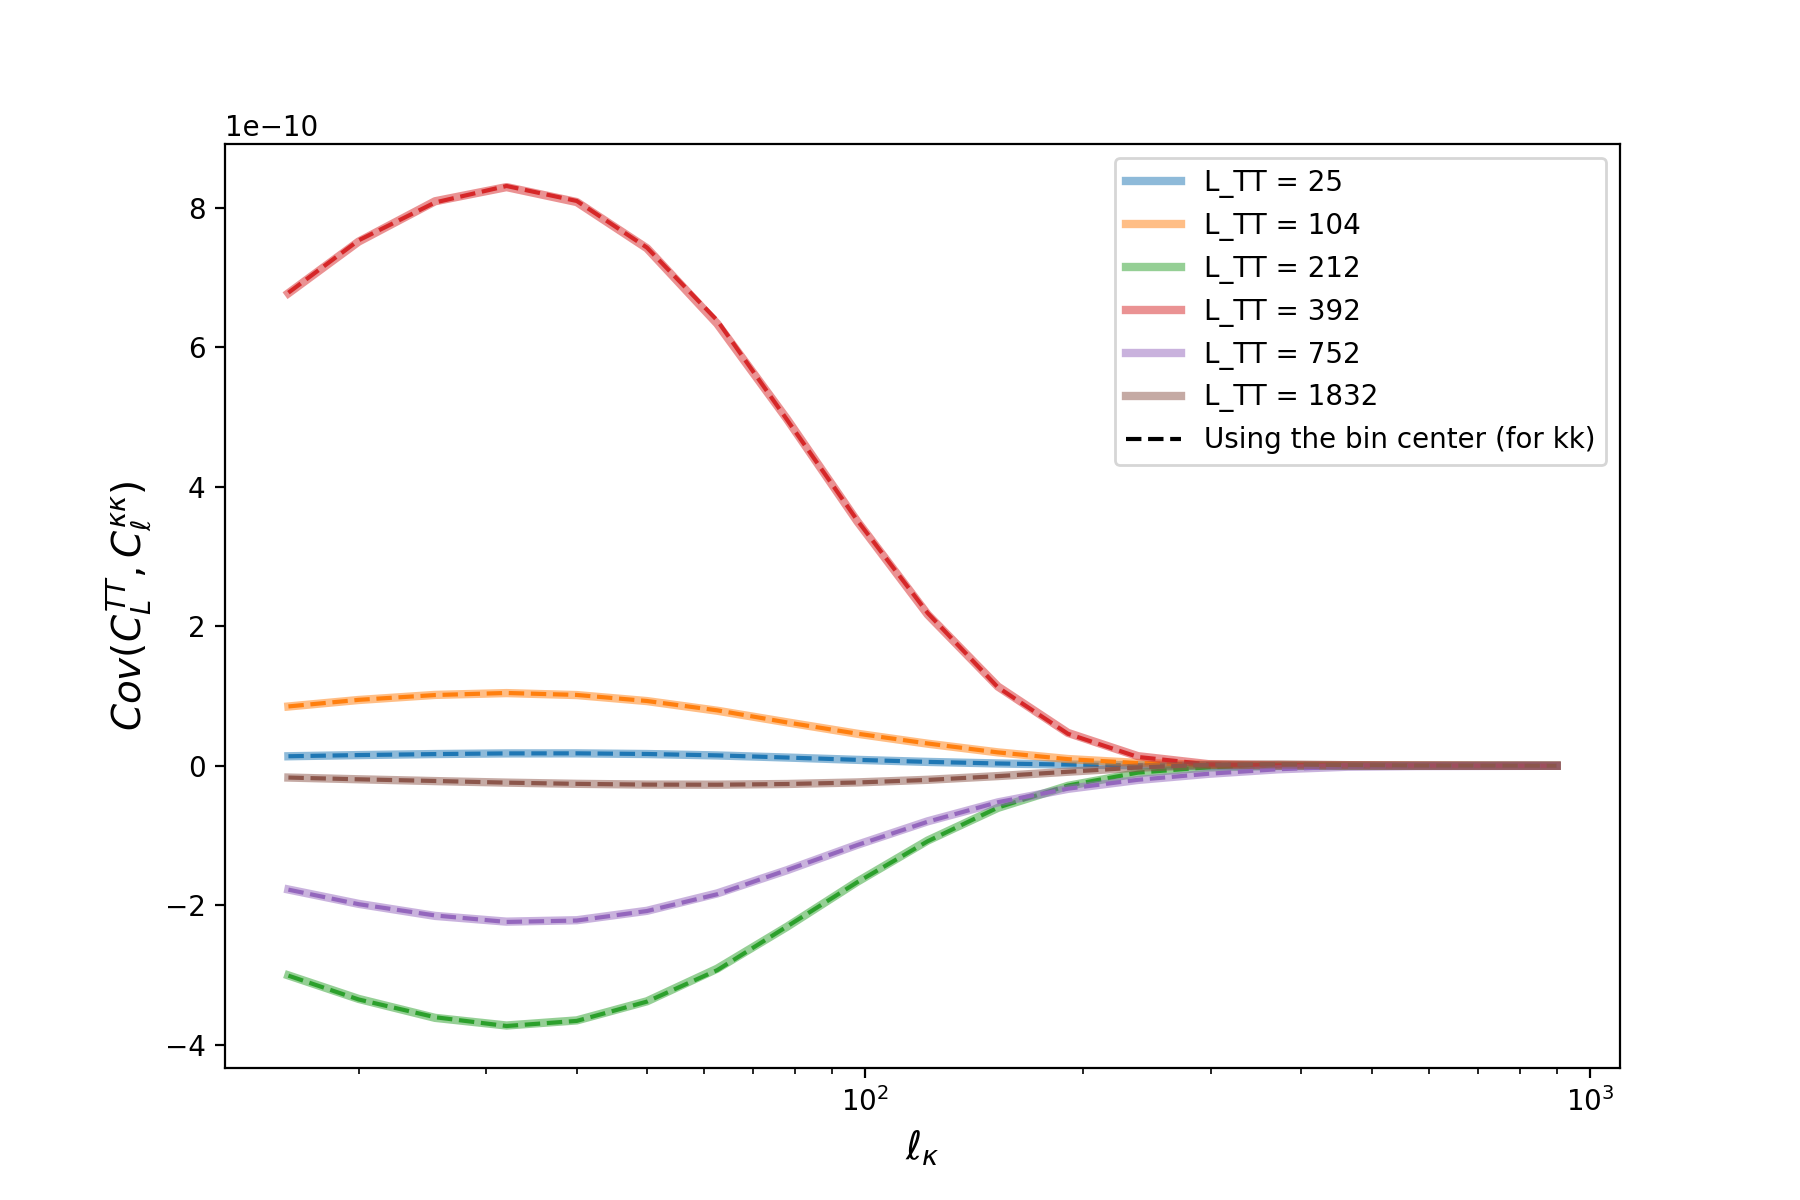

Text(0, 0.5, '$Cov(C_L^{TT},C_\\ell^{\\kappa\\kappa})$')

In [13]:
ell_cmb_center=(bpw.weight.T).dot(np.arange(lmax_CMB-1))

plt.figure(figsize=(9,6))
ind=0
for k in [0,2,5,10,20,50]:
    plt.plot(ell_kk_center,XCov_binned[k], color=f"C{ind}", alpha=0.5, lw=3, label=f"L_TT = {int(ell_cmb_center[k])}")
    plt.plot(ell_kk_center,XCov_center[k], color=f"C{ind}", ls='--')
    
    ind+=1
plt.plot([],[],ls='--', color='black', label='Using the bin center (for kk)')
plt.semilogx()
plt.legend()
plt.xlabel(r"$\ell_{\kappa}$", fontsize=14)
plt.ylabel(r"$Cov(C_L^{TT},C_\ell^{\kappa\kappa})$", fontsize=14)